P103 Python コード 4.1 pybayes_mcmc_reg_ex1.py
回帰モデルのベイズ分析の写経

★事前に google colab に登録しておき、google drive の Colab Notebooks フォルダの下に pybayes というフォルダを作っておくこと。

このコードでは自然共益事前分布を使った場合の回帰モデルを例として取り上げ、このベイズ分析を PyMC によって実行する方法を説明している。
本来は自然共益事前分布を使えばモンテカルロ法に頼る必要はないが、モテカルロ法でも同じ結果を再現できることを確認している。

In [1]:
# google colab のディストリビューションを確認しておく。Ubuntu のはず。
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [2]:
# google colab には標準で日本語フォントがインストールされないので、日本語フォントをインストールしておく
!sudo apt install fonts-takao

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-takao is already the newest version (00303.01-2ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [3]:
# 日本語フォント TakaoPGothic.ttf の有無を確認。
!ls /usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf

/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf


In [4]:
# PyMC3 のインストール

#!pip install pymc3
#!pip install arviz
!pip install git+https://github.com/pymc-devs/pymc3
!pip install git+git://github.com/arviz-devs/arviz.git

  Cloning https://github.com/pymc-devs/pymc3 to /tmp/pip-req-build-sl4d7y7d
  Running command git clone -q https://github.com/pymc-devs/pymc3 /tmp/pip-req-build-sl4d7y7d
  Created wheel for pymc3: filename=pymc3-3.8-cp36-none-any.whl size=40961907 sha256=7dbb690e78146e6468cfdc93e56734ff3331567a9e715aba171fccaad09cad20
  Stored in directory: /tmp/pip-ephem-wheel-cache-hi5p6eze/wheels/a1/e3/71/a696f2af0dd40bccc0ce672d616d21cc9dd90dbdd3f03242f4
Successfully built pymc3
  Cloning git://github.com/arviz-devs/arviz.git to /tmp/pip-req-build-ykgyf51l
  Running command git clone -q git://github.com/arviz-devs/arviz.git /tmp/pip-req-build-ykgyf51l
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for arviz: filename=arviz-0.6.1-cp36-none-any.whl size=2601365 sha256=ce5858aa2f9e73c599eecc0741a08229e6089a4dacaf65287dc923b16d2058d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-xusf7l5t/wheels/a5/04/05/b

In [5]:
# Google Driveにマウント
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# pybayes フォルダへ移動。
cd /content/gdrive/My Drive/Colab Notebooks/pybayes

/content/gdrive/My Drive/Colab Notebooks/pybayes


In [7]:
# pybayes フォルダにいることを確認。
!pwd

/content/gdrive/My Drive/Colab Notebooks/pybayes


----

以上が google colab で写経するコードを動かすための準備。

以下が本番。

In [0]:
# -*- coding: utf-8 -*-

import numpy as np
import scipy.stats as st
import scipy.linalg as la
import pymc3 as pm
import matplotlib.pyplot as plt

In [0]:
# 日本語フォントの設定

from matplotlib.font_manager import FontProperties
import sys
if sys.platform.startswith('win'):
  FontPath = 'C:\\Windows\\Fonts\\meiryo.ttc'
elif sys.platform.startswith('darwin'):
  FontPath = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'
elif sys.platform.startswith('linux'):
  FontPath = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
else:
  print('この Python コードが対応していない OS を使用しています。')
  sys.exit()

jpfont = FontProperties(fname=FontPath)

In [0]:
# 回帰モデルからのデータ生成

n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0 * x + u

In [0]:
# 回帰モデルの係数と誤差項の分散の事後分布の設定（自然共益事前分布）

b0 = np.zeros(2)
A0 = 0.2 * np.eye(2)
nu0 = 5.0
lam0 = 7.0
h0 = np.sqrt(np.diag(lam0 / nu0 * la.inv(A0)))
sd0 = np.sqrt(np.diag(la.inv(A0)))
regression_conjugate = pm.Model()

with regression_conjugate:
  # 事前分布の設定
  sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
  sigma = pm.math.sqrt(sigma2)
  a = pm.Normal('a', mu=b0[0], sd=sigma*sd0[0])
  b = pm.Normal('b', mu=b0[1], sd=sigma*sd0[1])
  # 尤度の設定
  y_hat = a + b * x
  likelihood = pm.Normal('y', mu=y_hat, sd=sigma, observed=y) 

一般に PyMC において with で始まる文に続くブロックの中では

with 確率モデルのオブジェクト:

　　　　事前分布の設定

　　　　尤度の設定

　　　　事後分布からのモンテカルロ標本の生成

という手順で事後分布の設定と乱数生成を行う。

with 文の中の代入 (=) は「定義式」を意味する。

In [12]:
# 事後分布からのサンプリング

n_draws = 5000
n_chains = 4
n_tune = 1000
with regression_conjugate:
  # 事後分布からのモンテカルロ標本の生成
  trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune,
                    random_seed=123)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [b, a, sigma2]


事後分布からの乱数生成に使う関数が pm.sample()

pm.sample(draws=生成回数, chains=乱数系列の数, tune=調整用の試行回数,
random_seed=乱数の初期値)

従って上では、4 * 5000 = 20000 個の乱数からなるモンテカルロ標本を作成している。

tune は前処理のために何回乱数生成を試行するかを指定する。デフォルトで 500 回だが、ここでは多めにして 1000 回としている。

オブジェクト trace は dict 型のデータ。前半の with 文で作成している、a, b, sigma2 に対応して、trace['a'], trace['b'], trace['sigma2'] が作成される。

In [0]:
# trace['a'] の中身をみてみる。
# print("trace['a'] =", trace['a'])
# ==> trace['a'] = [1.03450531 1.03833069 0.97734164 ... 0.87058488 1.11277932 1.12417185]

# trace['a'] のサイズをみてみる。
# print("len(trace['a']) =", len(trace['a']))
# ==> len(trace['a']) = 20000

In [14]:
# trace の中のモンテカルロ標本から事後統計量を計算し表示
#print(pm.summary(trace))
# google colab では下だと整形して表示される。
pm.summary(trace)

# P108 と結果が違うぞ…どーなってるの？ (汗)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.999,0.110,0.790,1.203,0.001,0.001,22553.0,22418.0,22605.0,14315.0,1.0
b,2.003,0.113,1.784,2.210,0.001,0.001,23833.0,23833.0,24038.0,14322.0,1.0
sigma2,0.587,0.118,0.387,0.811,0.001,0.001,20258.0,19125.0,20659.0,13263.0,1.0


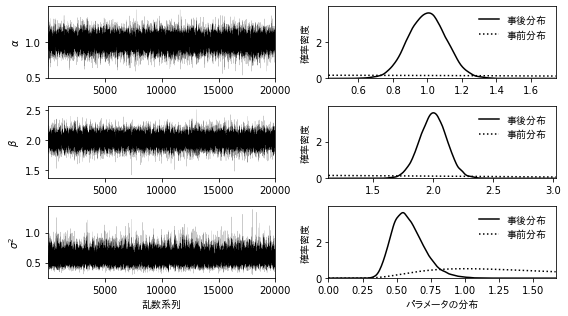

In [15]:
# 事後分布のグラフの作成

k = b0.size
param_names = ['a', 'b', 'sigma2']
labels = ['$\\alpha$', '$\\beta$', '$\\sigma^2$']

fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), 
                       facecolor='w')

# 下のループ。事前分布や事後分布の計算とグラフ描画が渾然一体となってわかりにくいのぅ。
for index in range(k+1):
  mc_trace = trace[param_names[index]]

  if index < k:
    # 0 <= index < k
    x_min = mc_trace.min() - 0.2 * np.abs(mc_trace.min())
    x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    prior = st.norm.pdf(x, loc=b0[index], scale=sd0[index])
  else:
    # index == k つまり、label = sigma2、一番下のグラフの場合
    x_min = 0.0
    x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)

    # 横軸のラベル
    ax[index, 0].set_xlabel('乱数系列', fontproperties=jpfont)
    ax[index, 1].set_xlabel('パラメータの分布', fontproperties=jpfont)
  
  # 左のグラフ：横軸は試行数 1 〜 n_draws*n_chains、縦軸はパラメータの値
  ax[index, 0].plot(mc_trace, 'k-', linewidth=0.1)
  ax[index, 0].set_xlim(1, n_draws*n_chains)
  ax[index, 0].set_ylabel(labels[index], fontproperties=jpfont)

  # 右のグラフ：横軸はパラメータの値の最小値〜最大値、縦軸は事前分布／事後分布
  posterior = st.gaussian_kde(mc_trace).evaluate(x)
  ax[index, 1].plot(x, posterior, 'k-', label='事後分布')
  ax[index, 1].plot(x, prior, 'k:', label='事前分布')
  ax[index, 1].set_xlim(x_min, x_max)
  ax[index, 1].set_ylim(0, 1.1*posterior.max())
  ax[index, 1].set_ylabel('確率密度', fontproperties=jpfont)
  ax[index, 1].legend(loc='best', frameon=False, prop=jpfont)

plt.tight_layout()
plt.savefig('pybayes_fig_mcmc_reg_ex1.png', dpi=300)
plt.show()

In [16]:
# 画像ファイル pybayes_fig_mcmc_reg_ex1.png が保存されていることを確認。
!ls pybayes_fig_mcmc_reg_ex1.png

pybayes_fig_mcmc_reg_ex1.png
